### Notes and thoughts

#### Current best ideas / runs that work / etc.
- Batch size = ~1/6th of training data size seems to make all the difference
- nfilters is only 16 for a single class
- Perhaps the best method is to train 10 models, one for each class

#### Ideas
- Weight map: sum the total area of all classes in y, then calculate each class' proportion of the total and use `1-value` in place of 1 in the binary mask. This will cause low frequency classes to contribute more to the total loss, i.e. penalizing the model when it fails to predict low frequency classes.

#### Data augmentation / image manipulation
- [Histogram Equalization](http://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_equalize.html#sphx-glr-auto-examples-color-exposure-plot-equalize-py) (also see [here](https://www.kaggle.com/gabrielaltay/dstl-satellite-imagery-feature-detection/exploring-color-scaling-images/discussion), [here](http://adilmoujahid.com/posts/2016/06/introduction-deep-learning-python-caffe/) and [here](https://medium.com/@vivek.yadav/improved-performance-of-deep-learning-neural-network-models-on-traffic-sign-classification-using-6355346da2dc#.x9nidcsh6))
- Rotation (with reflection): see data-augmentation.ipynb
- Image normalization: see image-preprocessing-new.ipynb

#### Overfitting solutions
- CNNs are supposed to be more robust to this because of the shared weight matrix of each filter
- **Data augmentation!**
- L2 regularization (added into the layers via `W_regularizer=l2(l=0.01)` parameter)
- Dropout hurts the model in my experience...

##### U-Net architecture

See [here](https://github.com/jocicmarko/ultrasound-nerve-segmentation/blob/master/train.py#L19) for code and [here](https://arxiv.org/pdf/1505.04597.pdf) for the original literature.

In [1]:
%reset
import numpy as np
from keras.models import Model
from keras.layers import Input, merge, Activation, Convolution2D, MaxPooling2D, UpSampling2D, ZeroPadding2D, Cropping2D, BatchNormalization
from keras.optimizers import Adadelta, Adam
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from keras import backend as K
from keras.regularizers import l2

K.set_image_dim_ordering('th')  # Theano dimension ordering in this code
# "tf" assumes (rows, cols, channels) while "th" assumes (channels, rows, cols)
# Possibly change this around natively in the data so the backend doesn't have to switch them
# Only necessary if I use TF!

from matplotlib import pyplot as plt

Once deleted, variables cannot be recovered. Proceed (y/[n])? 
Nothing done.


Using Theano backend.
Using gpu device 0: GRID K520 (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5105)
/home/ubuntu/anaconda3/lib/python3.5/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


### Helper functions

In [2]:
def norm_preds(preds):
    for i in range(preds.shape[0]):
        preds[i,0,:,:] = (preds[i,0,:,:].min() - preds[i,0,:,:])/(preds[i,0,:,:].min()-preds[i,0,:,:].max())
    return preds

In [3]:
def plot_all(i,classType):
    fig = plt.figure(figsize=(6,6))

    ax1 = fig.add_subplot(221)
    ax1.imshow(preds[i,0,...],cmap='spectral')

    ax2 = fig.add_subplot(222)
    ax2.imshow(np.rint(preds[i,0,...]),cmap='spectral')

    ax3 = fig.add_subplot(223)
    ax3.imshow(x[i,17,...],cmap='Greys')

    ax4 = fig.add_subplot(224)
    ax4.imshow(y_oneclass[i,classType,:,:],cmap='spectral')
    
    plt.show()
#plot_all(2,2,classType,0.5)
#push('PICTURES!','The plots are ready')

In [4]:
# Load the components of the pushbullet API
from pushbullet import Pushbullet

pb = Pushbullet('o.YFPNNPfGRekivaCGHa4qMSgjZt8zJ6FL')
phone = pb.devices[0]

# Run this cell after anything you want to be notified about!
def push(title='Done!',text='Whatever it was, it\'s done'):
    phone.push_note(title,text)

In [5]:
# Import the training data
def import_data():
    x = np.load('./data/x_augmented.npy','r')
    y = np.load('./data/y_augmented.npy','r')
    
    '''with open('./data/x_resized_array.pickle','rb') as f:
        x = pickle.load(f)
        x = x.astype(np.float32)
        
    with open('./data/y_resized_raster.pickle','rb') as f:
        y = pickle.load(f)
        y = y.astype(np.float32)'''
    
    y_oneclass = y[:,3:4,...]
    
    '''
    Classes:
    0 Buildings - large building, residential, non-residential, fuel storage facility, fortified building
    1 Misc. Manmade structures 
    2 Road 
    3 Track - poor/dirt/cart track, footpath/trail
    4 Trees - woodland, hedgerows, groups of trees, standalone trees
    5 Crops - contour ploughing/cropland, grain (wheat) crops, row (potatoes, turnips) crops
    6 Waterway 
    7 Standing water
    8 Vehicle Large - large vehicle (e.g. lorry, truck,bus), logistics vehicle
    9 Vehicle Small - small vehicle (car, van), motorbike
    '''
    
    return x, y, y_oneclass

In [6]:
run = 59

In [7]:
x, y, y_oneclass = import_data()

In [8]:
%%time
'''
V2.0 U-Net with batchnorm
'''
def builder(img_rows = x.shape[2],img_cols = x.shape[3],
            nfilters = 32,activation = 'relu',init = 'he_normal',
            lr=1.0,decay=0.0,momentum=0.0, nesterov=False,reg=0.01):
    
    def jaccard(y_true, y_pred,smooth=1.):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)
    
    def Conv2DReluBatchNorm(n_filter, w_filter, h_filter, inputs, activation='relu',init='he_uniform',dropout=0.2):
        return BatchNormalization(mode=0, axis=1)(Activation(activation=activation)(Convolution2D(n_filter, w_filter, h_filter, border_mode='same',init=init,W_regularizer=l2(reg))(inputs)))
        
    def up_conv(nfilters,filter_factor,inputs,init=init,activation=activation):
        return Convolution2D(nfilters*filter_factor, 2, 2, border_mode='same',init=init,activation=activation,W_regularizer=l2(reg))(UpSampling2D(size=(2, 2))(inputs))
    
    inputs = Input((20, img_rows, img_cols))
    padded = ZeroPadding2D(padding=(12,12))(inputs)
    
    conv1 = Conv2DReluBatchNorm(nfilters, 3, 3, padded, activation=activation,init=init)
    conv1 = Conv2DReluBatchNorm(nfilters, 3, 3, conv1, activation=activation,init=init)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2DReluBatchNorm(nfilters*2, 3, 3, pool1, activation=activation,init=init)
    conv2 = Conv2DReluBatchNorm(nfilters*2, 3, 3, conv2, activation=activation,init=init)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2DReluBatchNorm(nfilters*4, 3, 3, pool2, activation=activation,init=init)
    conv3 = Conv2DReluBatchNorm(nfilters*4, 3, 3, conv3, activation=activation,init=init)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2DReluBatchNorm(nfilters*8, 3, 3, pool3, activation=activation,init=init)
    conv4 = Conv2DReluBatchNorm(nfilters*8, 3, 3, conv4, activation=activation,init=init)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2DReluBatchNorm(nfilters*16, 3, 3, pool4, activation=activation,init=init)
    conv5 = Conv2DReluBatchNorm(nfilters*16, 3, 3, conv5, activation=activation,init=init)
        
    up6 = merge([up_conv(nfilters,8,conv5), conv4], mode='concat', concat_axis=1)
    conv6 = Conv2DReluBatchNorm(nfilters*8, 3, 3, up6, activation=activation,init=init)
    conv6 = Conv2DReluBatchNorm(nfilters*8, 3, 3, conv6, activation=activation,init=init)

    up7 = merge([up_conv(nfilters,4,conv6), conv3], mode='concat', concat_axis=1)
    conv7 = Conv2DReluBatchNorm(nfilters*4, 3, 3, up7, activation=activation,init=init)
    conv7 = Conv2DReluBatchNorm(nfilters*4, 3, 3, conv7, activation=activation,init=init)

    up8 = merge([up_conv(nfilters,2,conv7), conv2], mode='concat', concat_axis=1)
    conv8 = Conv2DReluBatchNorm(nfilters*2, 3, 3, up8, activation=activation,init=init)
    conv8 = Conv2DReluBatchNorm(nfilters*2, 3, 3, conv8, activation=activation,init=init)

    up9 = merge([up_conv(nfilters,1,conv8), conv1], mode='concat', concat_axis=1)
    conv9 = Conv2DReluBatchNorm(nfilters, 3, 3, up9, activation=activation,init=init)
    conv9 = Conv2DReluBatchNorm(nfilters, 3, 3, conv9, activation=activation,init=init)

    conv10 = Conv2DReluBatchNorm(1, 1, 1, conv9, activation='relu',init=init)
    cropped = Cropping2D(cropping=((12,12), (12,12)))(conv10)
    output = Activation(activation='sigmoid')(cropped)
    
    model = Model(input=inputs, output=output)
    
    model.compile(optimizer=Adam(lr=lr,decay=decay), loss='binary_crossentropy', metrics=[jaccard])
    
    return model

model = builder(img_rows=x.shape[2],img_cols=x.shape[3],
            nfilters=4,activation='relu',init='he_normal',
            lr=0.01,decay=0,momentum=0,reg=0.01)

#push('The model is compiled','')

CPU times: user 1.15 s, sys: 23.1 ms, total: 1.17 s
Wall time: 1.17 s


In [ ]:
run += 1
def train_and_predict(model,fit=True,use_existing=False):
    print('This is run number: '+ str(run) + '...')
    
    if use_existing:
        model.load_weights('./data/unet.hdf5')
        
    if fit:
        
        print('Fitting model...')
        print('-'*30)
        
        quitter = EarlyStopping(monitor='loss', min_delta=0.001, patience=100, verbose=1, mode='auto')
        lrreducer = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=10, verbose=1, mode='auto', epsilon=0.001, cooldown=2, min_lr=0)
        model_checkpoint = ModelCheckpoint('./data/model_weights_class_3_run_'+str(run)+'.hdf5', monitor='loss', save_best_only=True)
        csvlogger = CSVLogger('./data/training_log_run_'+str(run), separator=',', append=False)

        #tensorboard = TensorBoard(log_dir='./logs/'+'run_'+str(run), histogram_freq=0, write_graph=True, write_images=False)
        '''
        screen -S tensorboard
        tensorboard --logdir=logs
        <ctrl + a,d to exit>
        screen -r tensorboard
        '''
        
        model.fit(x, y_oneclass,
                  batch_size=30,
                  nb_epoch=2000,
                  verbose=1,
                  shuffle=True,
                  callbacks=[model_checkpoint,quitter,csvlogger],
                  validation_split=0.2,
                  initial_epoch=0)
    
        print('Predicting masks on test data...')
        print('-'*30)
        
    imgs_mask_test = model.predict(x, verbose=1)
    np.save('jaccard_preds_all_data.npy', imgs_mask_test)
    
    return model

model = train_and_predict(model,fit=True,use_existing=False)
push('Training is done',
     'Train loss: %f, train jaccard: %f, val loss %f, val jaccard%f' %(model.history.history['loss'][-1],model.history.history['jaccard'][-1],model.history.history['val_loss'][-1],model.history.history['val_jaccard'][-1]))

This is run number: 60...
Fitting model...
------------------------------


In [12]:
preds = np.load('jaccard_preds_all_data.npy')

In [36]:
model.evaluate(x[120:150,...],y_oneclass[120:150,...])

30/30 [==============================] - 0s


[0.50465971231460571, 0.15975004434585571]

121


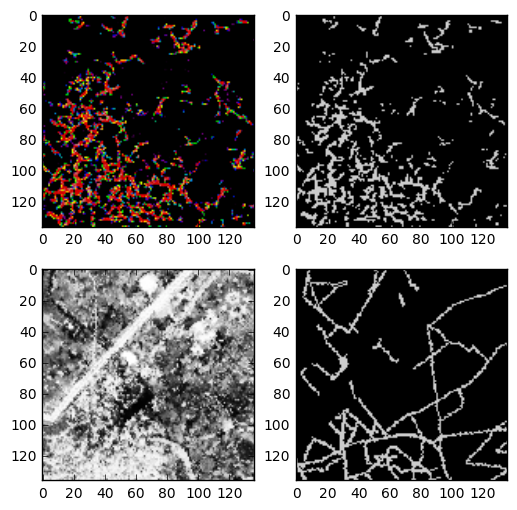

In [51]:
norm = False
if norm:
    preds = norm_preds(preds)
i = np.random.choice(range(120,150),1)[0]
print(i)
plot_all(i,0)

In [ ]:
def plot_everything():
    fig = plt.figure(figsize=(12,36))
    #num = np.random.randint(10,25,10)
    num = np.arange(0,10)
    for i in range(1,10):
        ax1 = fig.add_subplot(10,8,8*i-7)
        ax1.imshow(preds[num[i],0,...],cmap='spectral')
        
        ax2 = fig.add_subplot(10,8,8*i-6)
        ax2.imshow(y_oneclass[num[i],0,...],cmap='spectral')
        
        ax3 = fig.add_subplot(10,8,8*i-5)
        ax3.imshow(preds[num[i],1,...],cmap='spectral')
        
        ax4 = fig.add_subplot(10,8,8*i-4)
        ax4.imshow(y_oneclass[num[i],1,...],cmap='spectral')
        
        ax5 = fig.add_subplot(10,8,8*i-3)
        ax5.imshow(preds[num[i],2,...],cmap='spectral')
        
        ax6 = fig.add_subplot(10,8,8*i-2)
        ax6.imshow(y_oneclass[num[i],2,...],cmap='spectral')
        
        ax7 = fig.add_subplot(10,8,8*i-1)
        ax7.imshow(preds[num[i],3,...],cmap='spectral')
        
        ax8 = fig.add_subplot(10,8,8*i)
        ax8.imshow(y_oneclass[num[i],3,...],cmap='spectral')
        
    plt.show()
plot_everything()

In [ ]:
plot_classifier(model)

### Defunct bits and pieces

In [8]:
def load_cancelled(model):
    model.load_weights('./data/model_weights_class_3_run_54.hdf5')
    imgs_mask_test = model.predict(x, verbose=1)
    return imgs_mask_test

preds = load_cancelled(model)

150/150 [==============================] - 2s     


In [15]:
def plot_classifier(model):
    fig = plt.figure(figsize=(12, 6))

    ax = fig.add_subplot(111)
    ax.plot(model.history.history['loss'], "-",color='blue',label="Training final loss: "+str(round(model.history.history['loss'][-1],4)))
    ax.plot(model.history.history['jaccard'], "-",color='orange',label="testing final loss: "+str(round(model.history.history['jaccard'][-1],4)))
    #ax.set_xlim([0, epochs])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Jaccard / Loss')
    plt.legend(loc='best')
    ax.set_title('Metrics vs time (epochs)')
    
    '''ax = fig.add_subplot(122)
    ax.plot(model.history['acc'], "-",color='blue',label="Training final acc: "+str(round(model.history['acc'][-1],4)))
    ax.plot(model.history['val_acc'], "-",color='orange',label="testing final acc: "+str(round(model.history['val_acc'][-1],4)))
    #ax.set_xlim([0, epochs])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    plt.legend(loc='best')
    ax.set_title('Accuracy vs time (epochs)')    
    '''
    plt.show()

In [7]:
# Import the training data
def import_data(load_whitened = False, normalize = True):
    if load_whitened:
        with open('./data/x_whitened_resized_array.pickle','rb') as f:
            x = pickle.load(f)
            x = x.astype('float32')
    else:
        with open('./data/x_resized_array.pickle','rb') as f:
            x = pickle.load(f)
            x = x.astype('float32')
            # Normalize data to max values
            for i in range(x.shape[0]):
                for j in range(x.shape[1]):
                    x[i,j,:,:] *= 1/x[i,j,:,:].max()
                    
    # Normalize values between 1 and 0
    if normalize:
        for i in range(x.shape[0]):
            for j in range(x.shape[1]):
                #x[i,j,:,:] /= x[i,j,:,:].max()
                x[i,j,:,:] = (x[i,j,:,:].min() - x[i,j,:,:])/(x[i,j,:,:].min() - x[i,j,:,:].max())

    with open('./data/y_resized_raster.pickle','rb') as f:
        y = pickle.load(f)
        y = y.astype(np.float32)
        
    y_oneclass = y[:,1:6,...]
    
    '''
    Classes:
    0 Buildings - large building, residential, non-residential, fuel storage facility, fortified building
    1 Misc. Manmade structures 
    2 Road 
    3 Track - poor/dirt/cart track, footpath/trail
    4 Trees - woodland, hedgerows, groups of trees, standalone trees
    5 Crops - contour ploughing/cropland, grain (wheat) crops, row (potatoes, turnips) crops
    6 Waterway 
    7 Standing water
    8 Vehicle Large - large vehicle (e.g. lorry, truck,bus), logistics vehicle
    9 Vehicle Small - small vehicle (car, van), motorbike
    '''
    
    return x, y, y_oneclass
    
    # Just use a single class: roads
    #y = y[:,4,:,:]
    #y = y[:,np.newaxis,:,:]

    # y = y.reshape(y.shape[0],-1)
    # x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25, random_state=42)

In [2]:
def np_jaccard(y_true,y_pred,smooth=1.):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true * np.rint(y_pred))
    return (intersection+smooth) / (np.sum(y_true) + np.sum(y_pred) - intersection+smooth)